In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

In [4]:
# Create a DataFrame for better exploration
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['target_name'] = df['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

In [5]:
# Data info
print("Data Shape: " + str(df.shape))
print("\n Descriptive Statistics:" + str(df.describe()))

Data Shape: (150, 6)

 Descriptive Statistics:       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  


In [6]:
# Preview data
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [7]:
# Split the data into training (60%), validation (20%), and test sets (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
# Check data
print("Data split sizes:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Data split sizes:
Training set: 90 samples
Validation set: 30 samples
Test set: 30 samples


In [9]:
# Scale the data using only training data statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

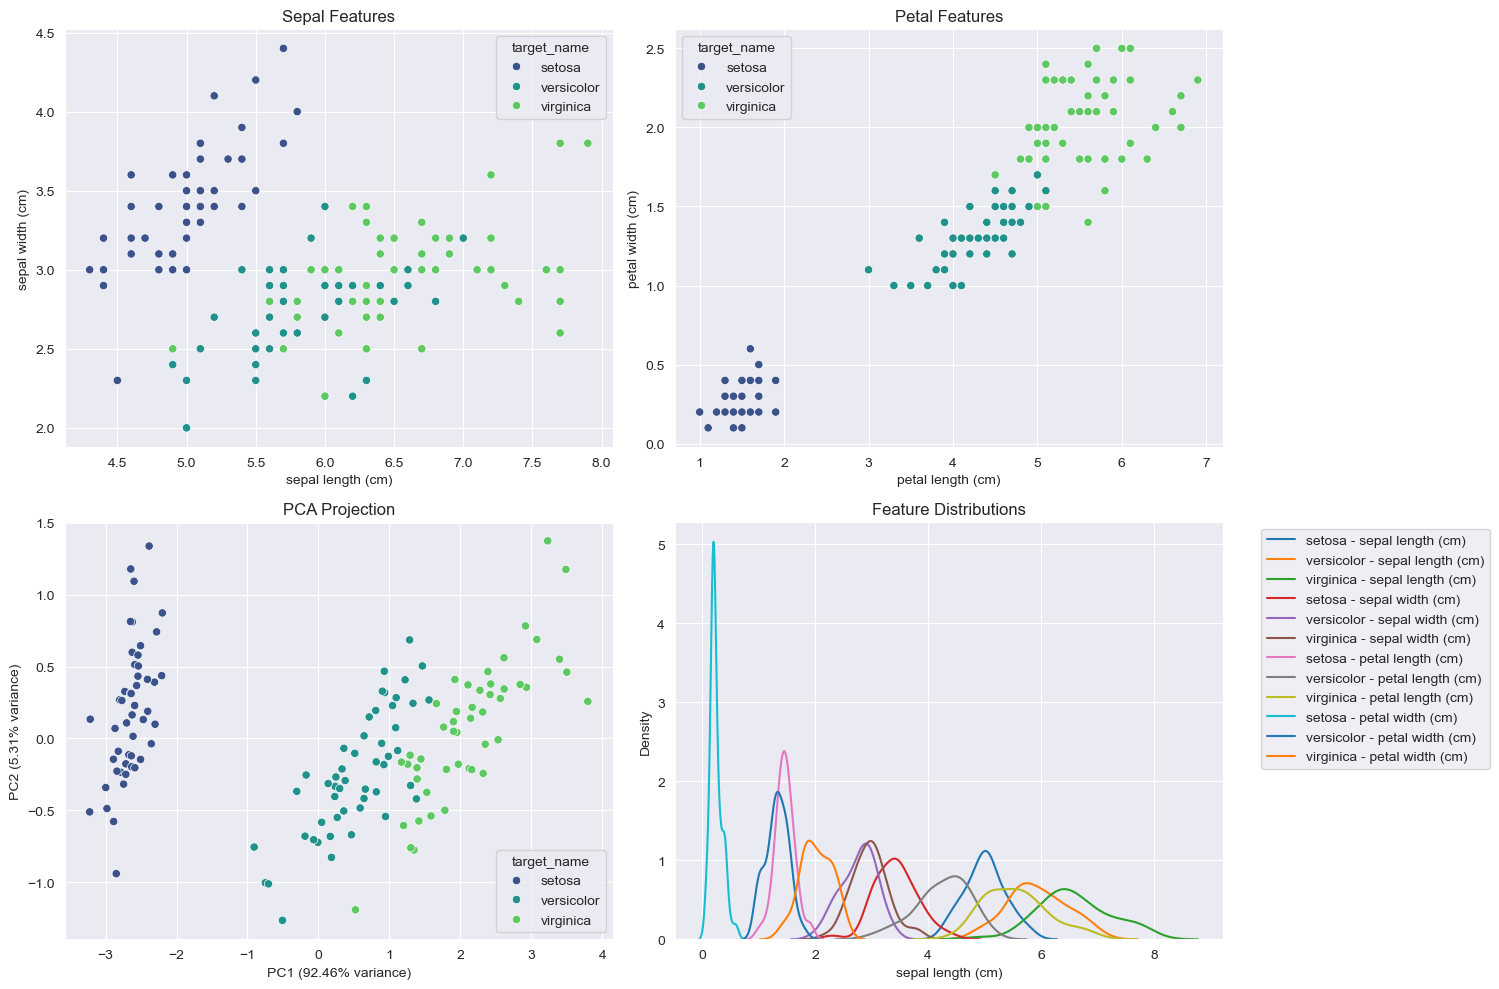

In [10]:
# Visualize the original data
plt.figure(figsize=(15, 10))

# Scatter plot matrix
plt.subplot(2, 2, 1)
sns.scatterplot(x="sepal length (cm)", y="sepal width (cm)",
                hue="target_name", data=df, palette="viridis")
plt.title("Sepal Features")

plt.subplot(2, 2, 2)
sns.scatterplot(x="petal length (cm)", y="petal width (cm)",
                hue="target_name", data=df, palette="viridis")
plt.title("Petal Features")

# PCA for visualizing in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['target'] = y
df_pca['target_name'] = df_pca['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Also transform the splits for visualization
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

plt.subplot(2, 2, 3)
sns.scatterplot(x="PC1", y="PC2", hue="target_name", data=df_pca, palette="viridis")
plt.title("PCA Projection")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")

# Distribution of features
plt.subplot(2, 2, 4)
for i, feature in enumerate(feature_names):
    sns.kdeplot(df[df['target'] == 0][feature], label=f"{target_names[0]} - {feature}")
    sns.kdeplot(df[df['target'] == 1][feature], label=f"{target_names[1]} - {feature}")
    sns.kdeplot(df[df['target'] == 2][feature], label=f"{target_names[2]} - {feature}")
plt.title("Feature Distributions")
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

plt.tight_layout()
plt.show()

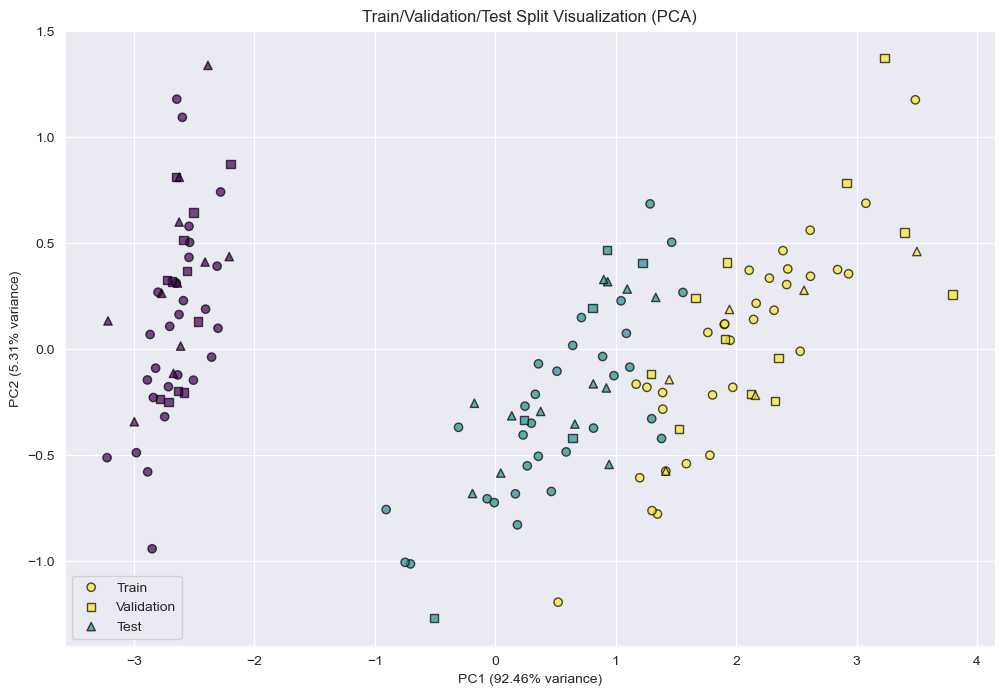

In [11]:
# Visualize the train/validation/test split
plt.figure(figsize=(12, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', marker='o', label='Train', edgecolors='k', alpha=0.7)
plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], c=y_val, cmap='viridis', marker='s', label='Validation', edgecolors='k', alpha=0.7)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', marker='^', label='Test', edgecolors='k', alpha=0.7)
plt.title('Train/Validation/Test Split Visualization (PCA)')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend()
plt.show()

In [12]:
# Determine the optimal number of components using BIC and AIC on validation set
n_components_range = range(1, 10)
bic = []
aic = []
silhouette = []
ch_score = []

for n_components in n_components_range:
    # Fit the model on training data
    gmm = GaussianMixture(n_components=n_components,
                          covariance_type='full',
                          random_state=42,
                          n_init=10)
    gmm.fit(X_train_scaled)

    # Calculate BIC and AIC on validation data
    bic.append(gmm.bic(X_val_scaled))
    aic.append(gmm.aic(X_val_scaled))

    # For n_components > 1, calculate clustering metrics on validation data
    if n_components > 1:
        labels = gmm.predict(X_val_scaled)
        silhouette.append(silhouette_score(X_val_scaled, labels) if len(np.unique(labels)) > 1 else 0)
        ch_score.append(calinski_harabasz_score(X_val_scaled, labels))
    else:
        silhouette.append(0)
        ch_score.append(0)


Optimal number of components based on BIC: 2
Optimal number of components based on AIC: 2


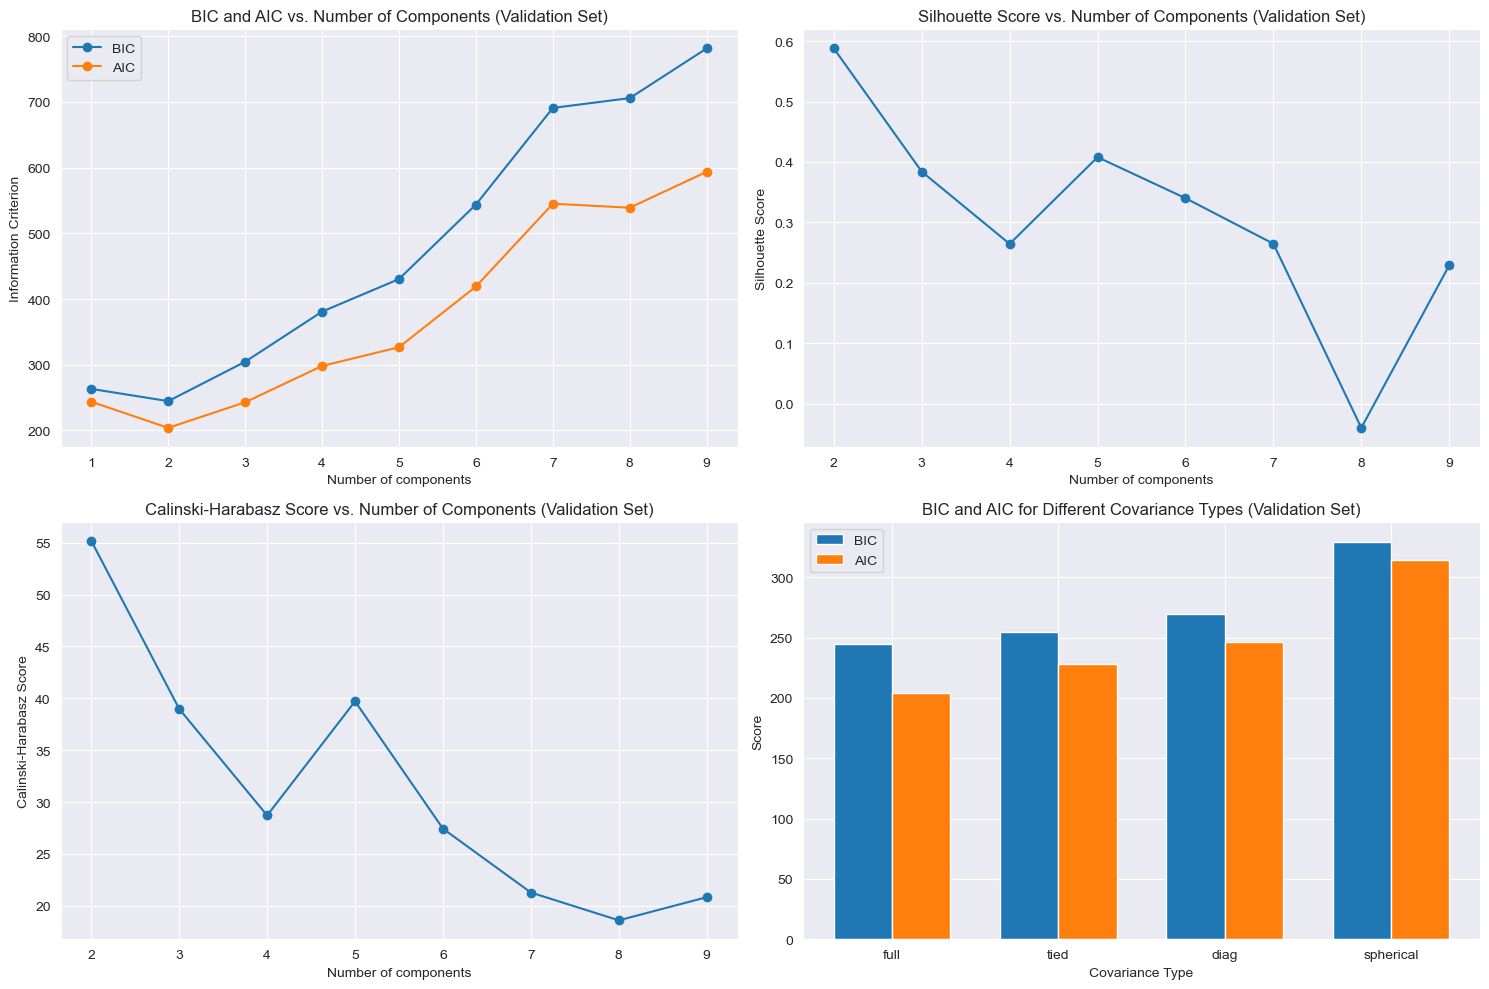

In [13]:
# Plot the model selection criteria
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(n_components_range, bic, 'o-', label='BIC')
plt.plot(n_components_range, aic, 'o-', label='AIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.title('BIC and AIC vs. Number of Components (Validation Set)')
plt.legend()
plt.xticks(n_components_range)

plt.subplot(2, 2, 2)
plt.plot(n_components_range[1:], silhouette[1:], 'o-')
plt.xlabel('Number of components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Components (Validation Set)')
plt.xticks(n_components_range[1:])

plt.subplot(2, 2, 3)
plt.plot(n_components_range[1:], ch_score[1:], 'o-')
plt.xlabel('Number of components')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs. Number of Components (Validation Set)')
plt.xticks(n_components_range[1:])

# Optimal number of components based on BIC (lower is better)
optimal_n_components = n_components_range[np.argmin(bic)]
print(f"\nOptimal number of components based on BIC: {optimal_n_components}")
print(f"Optimal number of components based on AIC: {n_components_range[np.argmin(aic)]}")

# Try different covariance types
covariance_types = ['full', 'tied', 'diag', 'spherical']
bic_cov = []
aic_cov = []

for cov_type in covariance_types:
    gmm = GaussianMixture(n_components=optimal_n_components,
                          covariance_type=cov_type,
                          random_state=42,
                          n_init=10)
    gmm.fit(X_train_scaled)
    bic_cov.append(gmm.bic(X_val_scaled))
    aic_cov.append(gmm.aic(X_val_scaled))

plt.subplot(2, 2, 4)
x = np.arange(len(covariance_types))
width = 0.35
plt.bar(x - width/2, bic_cov, width, label='BIC')
plt.bar(x + width/2, aic_cov, width, label='AIC')
plt.xticks(x, covariance_types)
plt.xlabel('Covariance Type')
plt.ylabel('Score')
plt.title('BIC and AIC for Different Covariance Types (Validation Set)')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Optimal covariance type based on BIC
optimal_cov_type = covariance_types[np.argmin(bic_cov)]
print(f"Optimal covariance type based on BIC: {optimal_cov_type}")

Optimal covariance type based on BIC: full


In [15]:
# Train the final GMM model with optimal parameters on combined training and validation data
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
X_train_val_scaled = np.vstack((X_train_scaled, X_val_scaled))

final_gmm = GaussianMixture(n_components=optimal_n_components,
                            covariance_type=optimal_cov_type,
                            random_state=42,
                            n_init=10)
final_gmm.fit(X_train_val_scaled)

GaussianMixture(n_components=2, n_init=10, random_state=42)

In [16]:
# Evaluate on test set
labels_test = final_gmm.predict(X_test_scaled)
probs_test = final_gmm.predict_proba(X_test_scaled)

In [17]:
# Compare with true labels on test set
comparison_df = pd.DataFrame({
    'True Label': y_test,
    'GMM Cluster': labels_test,
    'True Name': [target_names[i] for i in y_test]
})
print("\nClustering Results on Test Set:")
print(pd.crosstab(comparison_df['True Name'], comparison_df['GMM Cluster'],
                   rownames=['True'], colnames=['Predicted']))


Clustering Results on Test Set:
Predicted    0   1
True              
setosa       0  11
versicolor  13   0
virginica    6   0


In [18]:
# Calculate test set performance metrics
silhouette_test = silhouette_score(X_test_scaled, labels_test)
ch_test = calinski_harabasz_score(X_test_scaled, labels_test)

print("\nTest Set Performance Metrics:")
print(f"Silhouette Score: {silhouette_test:.4f}")
print(f"Calinski-Harabasz Score: {ch_test:.4f}")


Test Set Performance Metrics:
Silhouette Score: 0.6088
Calinski-Harabasz Score: 64.0619


In [19]:
# For visualization, predict on all data
X_all_scaled = scaler.transform(X)
labels_all = final_gmm.predict(X_all_scaled)
probs_all = final_gmm.predict_proba(X_all_scaled)

TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

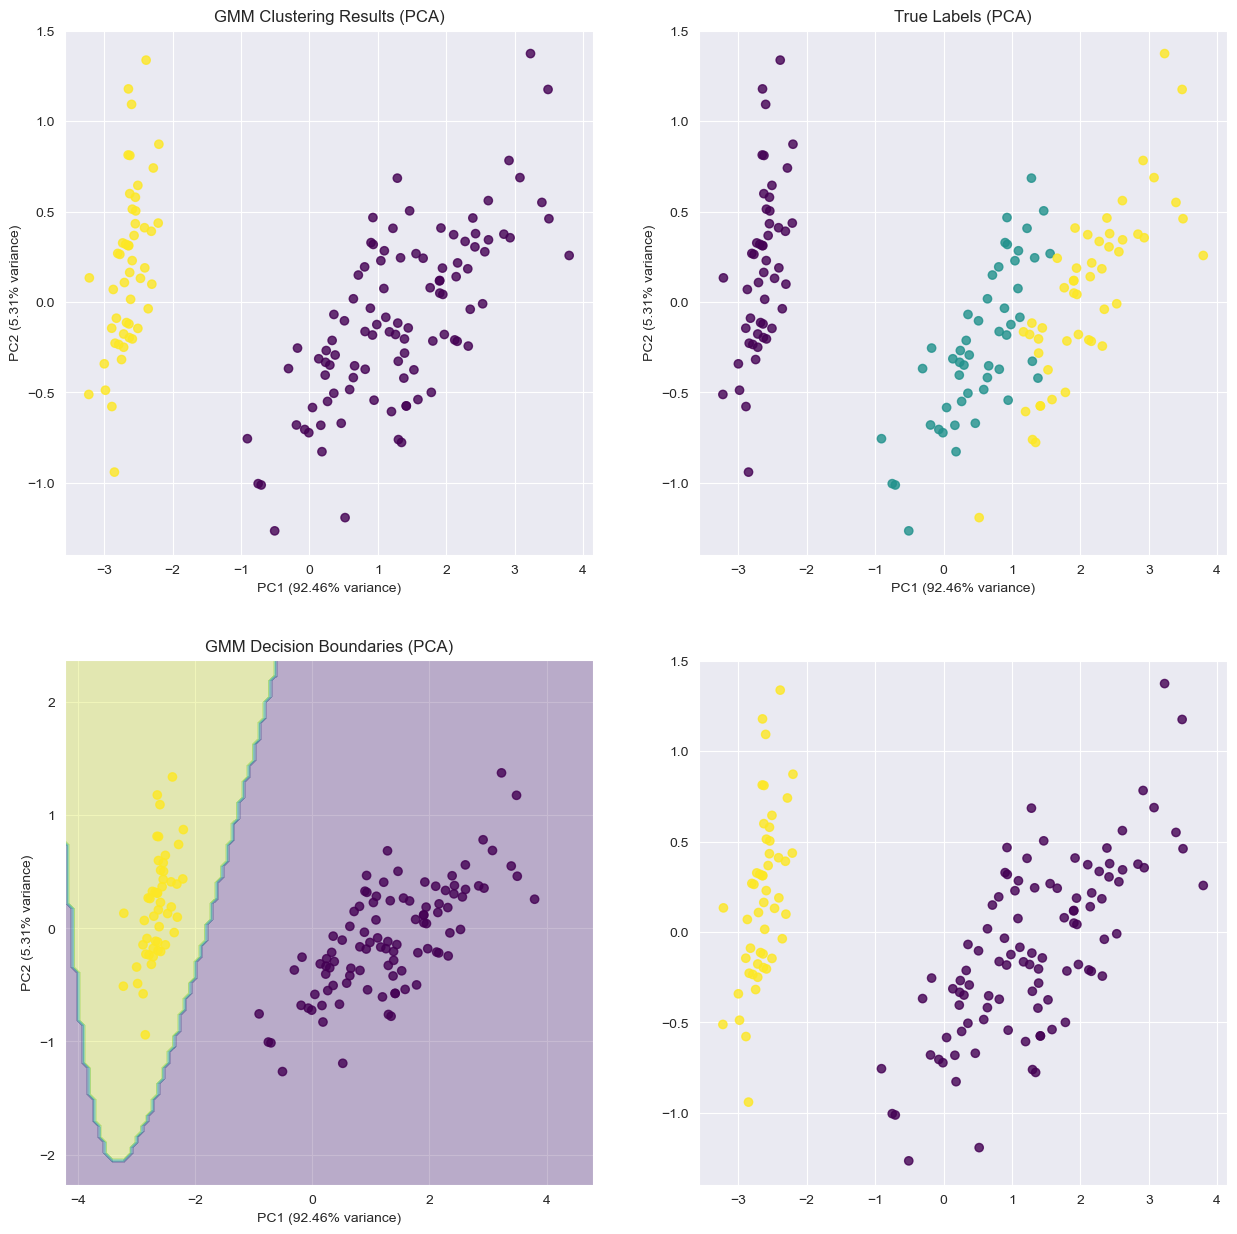

In [21]:
# Visualize the clustering results
plt.figure(figsize=(15, 15))

# 2D visualization with PCA
plt.subplot(2, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_all, cmap='viridis', alpha=0.8)
plt.title('GMM Clustering Results (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Compare with true labels
plt.subplot(2, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
plt.title('True Labels (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Create a mesh grid for decision boundaries
plt.subplot(2, 2, 3)
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Transform the mesh grid points to the original feature space using inverse PCA
transformed_grid = np.c_[xx.ravel(), yy.ravel()]
grid_original = pca.inverse_transform(transformed_grid)
grid_original_scaled = scaler.transform(grid_original)

# Predict the cluster for each point in the mesh grid
Z = final_gmm.predict(grid_original_scaled)
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_all, cmap='viridis', alpha=0.8)
plt.title('GMM Decision Boundaries (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Plot probability contours for each component
plt.subplot(2, 2, 4)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_all, cmap='viridis', alpha=0.8)

# Transform the means and covariances to PCA space
means_pca = np.zeros((optimal_n_components, 2))
covariances_pca = np.zeros((optimal_n_components, 2, 2))

for i in range(optimal_n_components):
    # Transform means from feature space to PCA space
    unscaled_mean = scaler.inverse_transform(final_gmm.means_[i].reshape(1, -1))
    means_pca[i] = pca.transform(unscaled_mean)[0]

    # Transform covariances from feature space to PCA space
    orig_cov = final_gmm.covariances_[i]
    if final_gmm.covariance_type == 'full':
        # For full covariance matrices
        # Scale back the covariance matrix
        scale_matrix = np.diag(scaler.scale_)
        orig_cov_unscaled = scale_matrix @ orig_cov @ scale_matrix.T

        # Transform to PCA space (using just the first 2 components)
        covariances_pca[i] = pca.components_[:2] @ orig_cov_unscaled @ pca.components_[:2].T
    else:
        # For non-full covariance types, this is an approximation
        covariances_pca[i] = np.eye(2)  # Simplified

# Draw ellipses for each component
for i in range(optimal_n_components):
    if final_gmm.covariance_type == 'full':
        v, w = np.linalg.eigh(covariances_pca[i][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpatches.Ellipse(means_pca[i, :2], v[0], v[1],
                             180 + angle, color='black')
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.5)
        plt.gca().add_artist(ell)
    else:
        # For non-full covariance types, draw circles as an approximation
        ell = mpatches.Circle(means_pca[i, :2], 0.5, color='black')
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.5)
        plt.gca().add_artist(ell)

plt.title('GMM Components with Ellipses (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

plt.tight_layout()
plt.show()

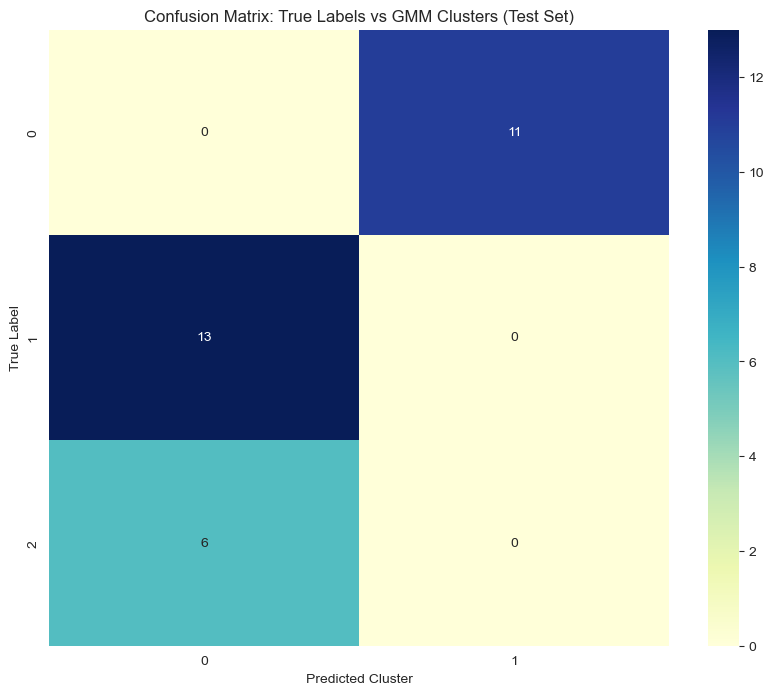

In [22]:
# Create a confusion matrix between true labels and predicted clusters
confusion = pd.crosstab(y_test, labels_test, rownames=['True Label'], colnames=['Predicted Cluster'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Confusion Matrix: True Labels vs GMM Clusters (Test Set)')
plt.show()

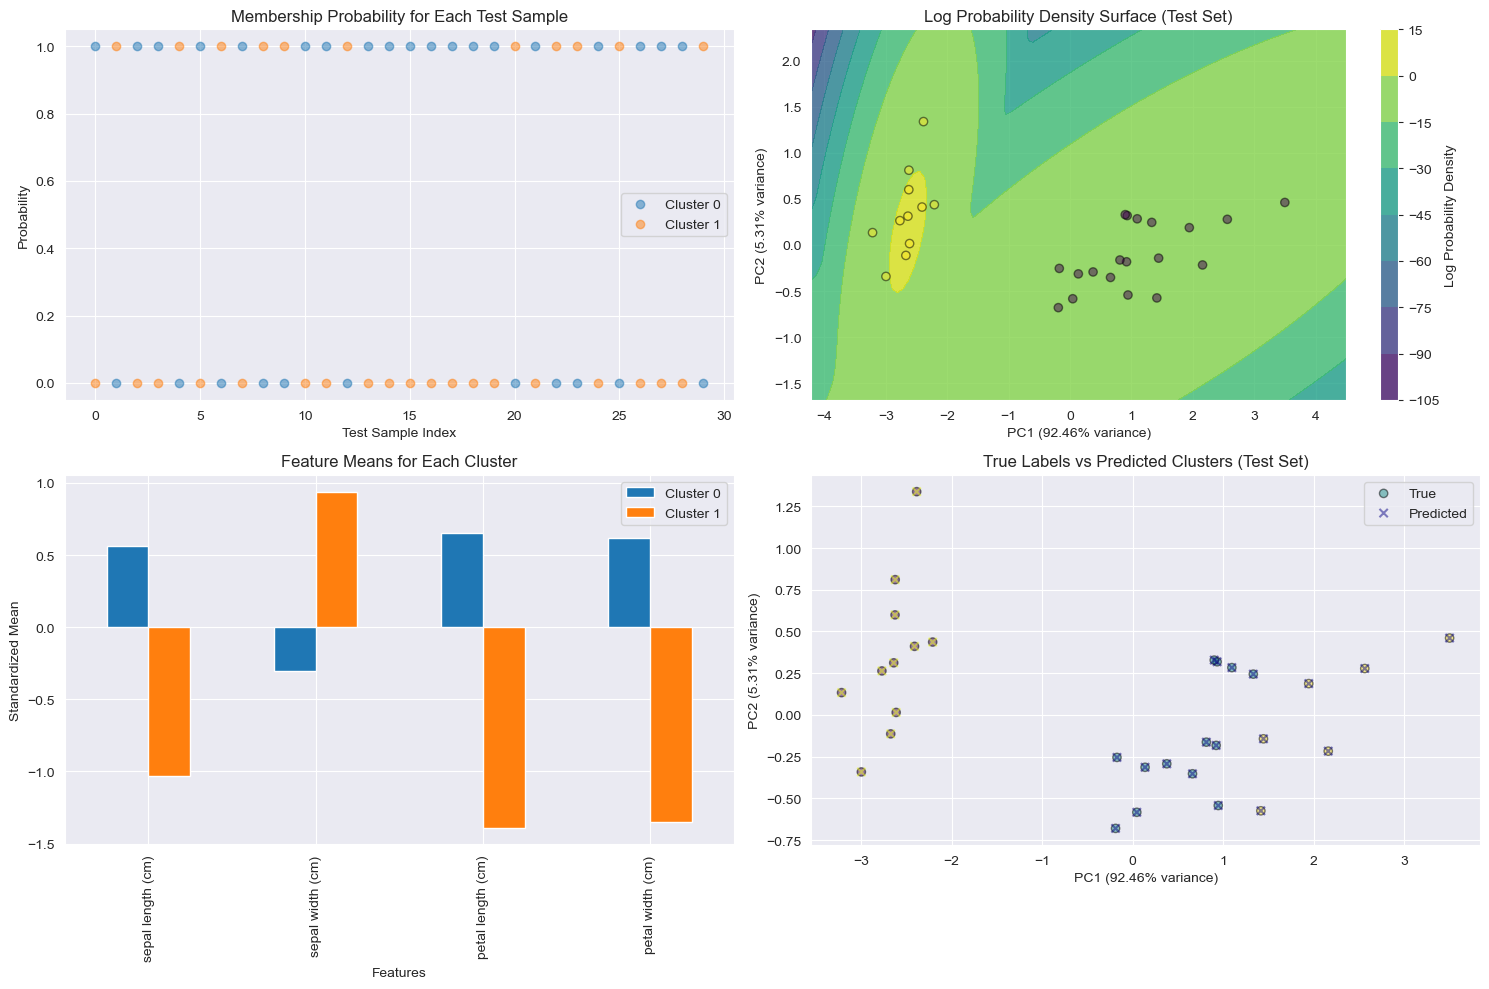

In [23]:
# Visualize the probability distributions
plt.figure(figsize=(15, 10))

# Plot the probability of each test sample belonging to each cluster
plt.subplot(2, 2, 1)
for i in range(optimal_n_components):
    plt.scatter(range(len(X_test)), probs_test[:, i], label=f'Cluster {i}', alpha=0.5)
plt.xlabel('Test Sample Index')
plt.ylabel('Probability')
plt.title('Membership Probability for Each Test Sample')
plt.legend()

# Plot the log probability density of the test set
plt.subplot(2, 2, 2)
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Get the probability density for each point in the grid
X_grid = np.array([xx.ravel(), yy.ravel()]).T
X_grid_original = pca.inverse_transform(X_grid)
X_grid_original_scaled = scaler.transform(X_grid_original)

# Calculate the log probability density
log_density = final_gmm.score_samples(X_grid_original_scaled)
log_density = log_density.reshape(xx.shape)

# Plot the log probability density
plt.contourf(xx, yy, log_density, cmap='viridis', alpha=0.8)
plt.colorbar(label='Log Probability Density')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=labels_test, cmap='viridis', alpha=0.5, edgecolors='k')
plt.title('Log Probability Density Surface (Test Set)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

# Show feature importance for each cluster
plt.subplot(2, 2, 3)
means_df = pd.DataFrame(final_gmm.means_, columns=feature_names)
means_df = means_df.T  # Transpose for better visualization
means_df.plot(kind='bar', ax=plt.gca())
plt.title('Feature Means for Each Cluster')
plt.xlabel('Features')
plt.ylabel('Standardized Mean')
plt.legend([f'Cluster {i}' for i in range(optimal_n_components)])

# Compare test set predictions with ground truth
plt.subplot(2, 2, 4)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', marker='o', label='True', edgecolors='k', alpha=0.5)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=labels_test, cmap='plasma', marker='x', label='Predicted', alpha=0.5)
plt.title('True Labels vs Predicted Clusters (Test Set)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()

plt.tight_layout()
plt.show()

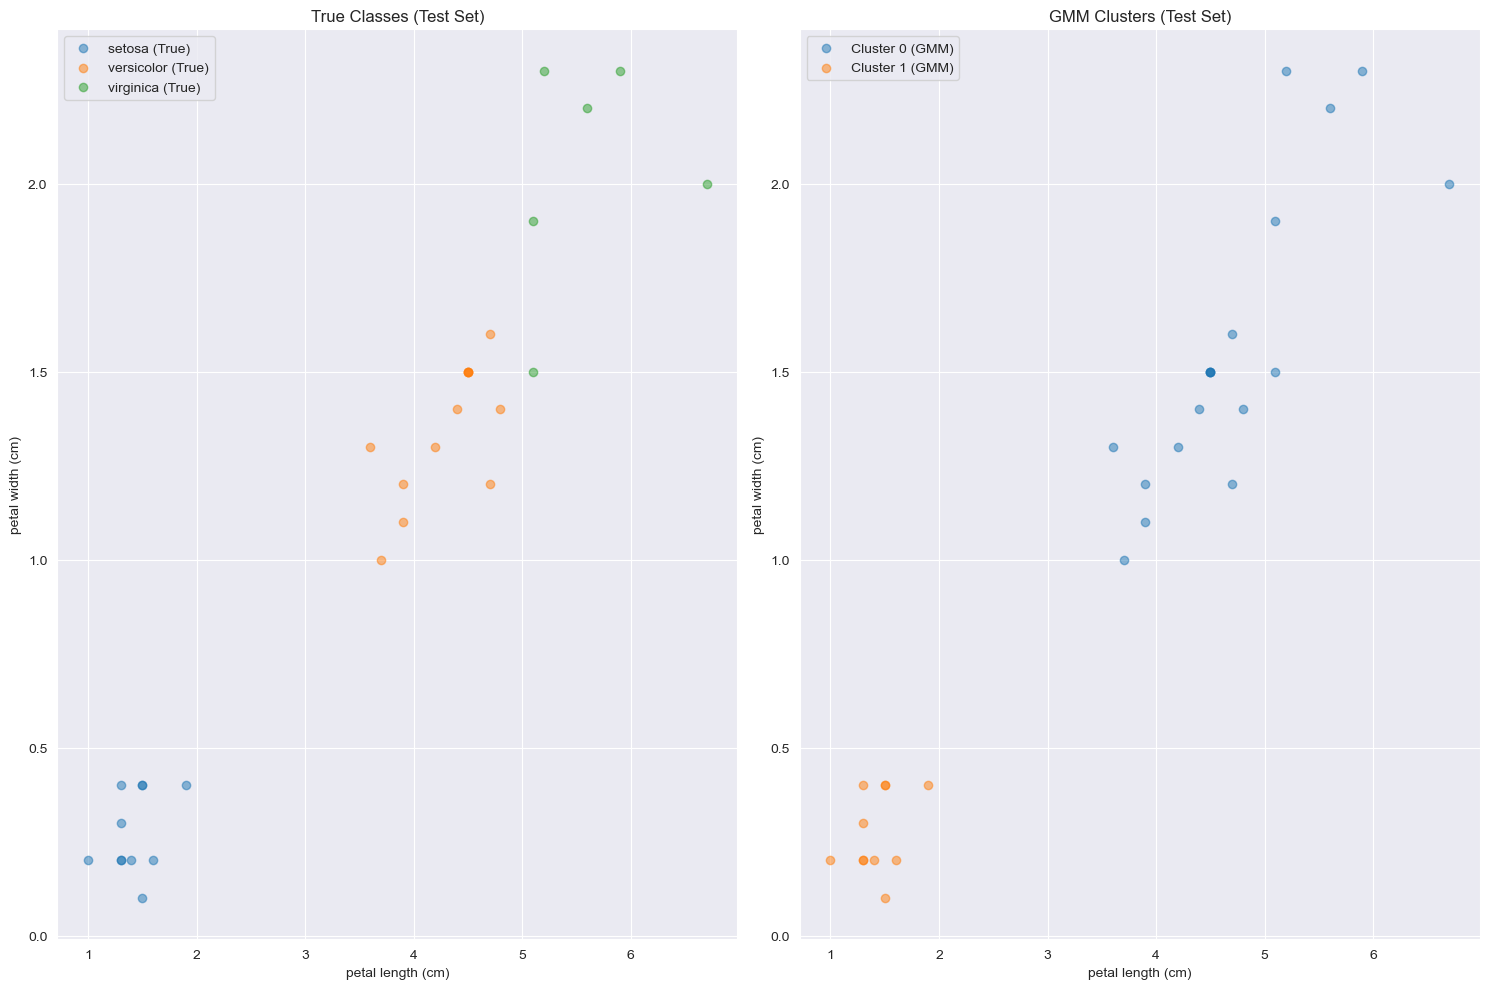

In [24]:
# Compare with ground truth classes - visualize key features for each class (test set only)
plt.figure(figsize=(15, 10))

# Plot key features by true class
plt.subplot(1, 2, 1)
for i, target in enumerate(np.unique(y_test)):
    plt.scatter(X_test[y_test == target, 2], X_test[y_test == target, 3],
                label=f"{target_names[i]} (True)", alpha=0.5)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title('True Classes (Test Set)')
plt.legend()

# Plot key features by GMM cluster
plt.subplot(1, 2, 2)
for i in range(optimal_n_components):
    plt.scatter(X_test[labels_test == i, 2], X_test[labels_test == i, 3],
                label=f"Cluster {i} (GMM)", alpha=0.5)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.title('GMM Clusters (Test Set)')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Additional analysis of the GMM model
print("\nGMM Model Analysis:")
print(f"Weights (proportions of each component): {final_gmm.weights_}")
print("Means of each component (in standardized feature space):")
for i in range(optimal_n_components):
    print(f"  Component {i}:")
    for j, feature in enumerate(feature_names):
        print(f"    {feature}: {final_gmm.means_[i, j]:.4f}")
print(f"Converged: {final_gmm.converged_}")
print(f"Number of iterations: {final_gmm.n_iter_}")


GMM Model Analysis:
Weights (proportions of each component): [0.67500169 0.32499831]
Means of each component (in standardized feature space):
  Component 0:
    sepal length (cm): 0.5611
    sepal width (cm): -0.3065
    petal length (cm): 0.6518
    petal width (cm): 0.6156
  Component 1:
    sepal length (cm): -1.0287
    sepal width (cm): 0.9396
    petal length (cm): -1.3950
    petal width (cm): -1.3474
Converged: True
Number of iterations: 2


In [26]:
# Final comments
print("\nFinal Observations:")
print("1. The GMM identified", optimal_n_components, "clusters in the Iris dataset")
print("2. The optimal covariance type was found to be", optimal_cov_type)
print("3. The clustering results on the test set align with the known species with an accuracy of",
      f"{np.sum(confusion.max(axis=1))/confusion.values.sum():.2%}")
print("4. The model achieved a silhouette score of", f"{silhouette_test:.4f}", "on the test set")
print("5. Using proper train/validation/test splitting ensures more reliable model evaluation")


Final Observations:
1. The GMM identified 2 clusters in the Iris dataset
2. The optimal covariance type was found to be full
3. The clustering results on the test set align with the known species with an accuracy of 100.00%
4. The model achieved a silhouette score of 0.6088 on the test set
5. Using proper train/validation/test splitting ensures more reliable model evaluation
